#Introduction
The main goal in this project is to get the MNIST from TF and then create or modify a new dataset having 75⋆75 images instead of 28⋆28. all the small images Are going to paste in the bigger images in a random locations. after preparing the dataset we train a model and the predict the class of each image and even the bouning box locations. To achieve this ambition Labels need to change a little. the classic and familiar MNIST contains 28 ⋆ 28 images and 1 single digit in the label for the corresponding image, but in the modified version we need to have 2 output and 2 kind of labels. first one should be the number (0-9) -that we change them to the OneHot version and we have 10 units for each image that 9 units are zero and only one of them is 1 representing the digit in the previous version. on the other hand we should store and use the coordinations of the bounding boxes. each bounding box is 28 ⋆ 28 ( the original size of the image). we need to store 4 numbers for each image too.

In other words we had the MNIST shape like {(60000, 28, 28, 1) as input images and (60000, 1) as output labels} but now we're going to have {(60000, 75, 75, 1) as input images, (60000, 10) and (60000, 4) as output Labels}.

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#⋆⋆⋆ Data ⋆⋆⋆ #

##Loading and pre-processing the Dataset##
**It can be skipped in later runs**
we get and modify the data here. we can store the final moification on the google drive for later uses.

( **ADVICE** : try to modify and save data and then disconnect the running GPU and reconnect it to clear the memory and then upload the final version of the data for training.)

In [ ]:
mnist  = tf.keras.datasets.mnist
(trainImages, trainLabels) , (testImages, testLabels)= mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
trainImages = tf.reshape(trainImages, (60000, 28, 28, 1))
trainLabels = tf.reshape(trainLabels, (60000, 1))
testImages = tf.reshape(testImages, (10000, 28, 28, 1))
testLabels = tf.reshape(testLabels, (10000, 1))


##Visualization before pre-processing##


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


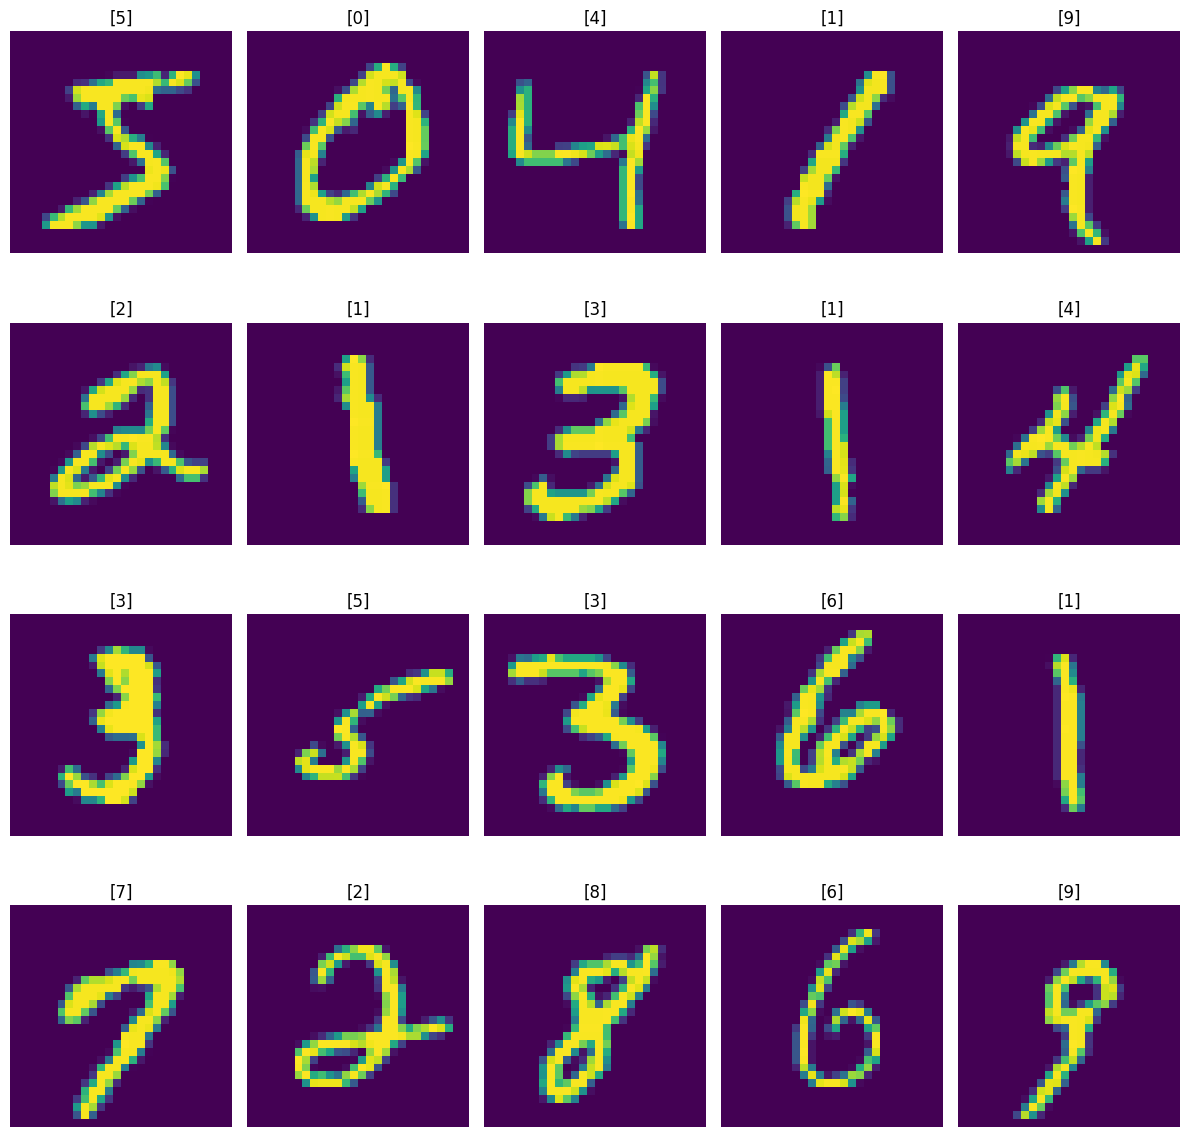

In [ ]:
figure, axes = plt.subplots(4, 5, figsize=(12, 12))
for i in range (len(trainImages)):
  ax_row = i //5
  ax_col = i % 5
  if ax_row ==4 or ax_col ==5:
    break
  ax = axes[ax_row][ax_col]
  ax.imshow(trainImages[i])
  ax.set_title(trainLabels[i].numpy())
  ax.axis('off')
plt.tight_layout()
plt.show()

##Functions for preparing the Data##
**it can be skipped in later runs**

The function below is getting the image and generating cordination for that image in range ( 0 , 48 ) and the reason for this action is because we have 28 pixels on original image and it should be in a boundry and not out of the image. if we put the image on the 58th pixel, it would paste  11 pixels out of the 75. and then the tf.image.pad_to_bounding_box() function gets the image and the max and min of the bounding box ( that are random numbers between 0 and 48) and then puts black padding around it to make the final image 75 ⋆ 75

In [ ]:
def imagePaste(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), np.array([xmin, ymin, xmax, ymax]))


we can use tf.map to utilize the gpu but I just did it like the way below.

In [ ]:
mod_trainImages = [None] * len(trainImages)
mod_trainLabels = [None] * len(trainImages)
mod_trainBboxes = [None] * len(trainImages)
for i in range(len(trainImages)):
  image, (label, bb) = imagePaste(trainImages[i], trainLabels[i])
  mod_trainImages[i] = image
  mod_trainLabels[i] = label
  mod_trainBboxes[i] = bb



In [ ]:
num_trainImages = np.asarray(mod_trainImages)
num_trainLabels = np.asarray(mod_trainLabels)
num_trainBboxes = np.asarray(mod_trainBboxes)



In [ ]:
print(num_trainImages.shape)
print(num_trainLabels.shape)
print(num_trainBboxes.shape)

(60000, 75, 75, 1)
(60000, 1, 10)
(60000, 4)


In [ ]:
mod_testImages = [None] * len(testImages)
mod_testLabels = [None] * len(testImages)
mod_testBboxes = [None] * len(testImages)
for i in range(len(testImages)):
  image, (label, bb) = imagePaste(testImages[i], testLabels[i])
  mod_testImages[i] = image
  mod_testLabels[i] = label
  mod_testBboxes[i] = bb



In [ ]:
num_testImages = np.asarray(mod_testImages)
num_testLabels = np.asarray(mod_testLabels)
num_testBboxes = np.asarray(mod_testBboxes)



In [ ]:
print(num_testImages.shape)
print(num_testLabels.shape)
print(num_testBboxes.shape)

(10000, 75, 75, 1)
(10000, 1, 10)
(10000, 4)


In [ ]:
num_trainLabels = np.reshape(num_trainLabels, (60000, 10))
num_testLabels = np.reshape(num_testLabels, (10000, 10))

In [ ]:
path = '/content/drive/My Drive/mnist_mod_num/'
np.save(path+'num_trainImages.npy', num_trainImages)
np.save(path+'num_trainLabels.npy', num_trainLabels)
np.save(path+'num_trainBboxes.npy', num_trainBboxes)
np.save(path+'num_testImages.npy', num_testImages)
np.save(path+'num_testLabels.npy', num_testLabels)
np.save(path+'num_testBboxes.npy', num_testBboxes)
print("All the data transfered to the Drive")

All the data transfered to the Drive


now its time to disconnect and delete runtime, then reconnect the GPU again

##Loading Data##


In [ ]:
path = '/content/drive/My Drive/mnist_mod_num/'
num_trainImages = np.load(path+'num_trainImages.npy')
num_trainLabels = np.load(path+'num_trainLabels.npy')
num_trainBboxes = np.load(path+'num_trainBboxes.npy')
num_testImages = np.load(path+'num_testImages.npy')
num_testLabels = np.load(path+'num_testLabels.npy')
num_testBboxes = np.load(path+'num_testBboxes.npy')

print(num_trainImages.shape, num_trainLabels.shape, num_trainBboxes.shape,
      num_testImages.shape, num_testLabels.shape, num_testBboxes.shape)

(60000, 75, 75, 1) (60000, 10) (60000, 4) (10000, 75, 75, 1) (10000, 10) (10000, 4)


##Useful functions for Plotting and Visualizations##
**MUST RUN**

In [ ]:
#@title Plot Utilities for Bounding Boxes [RUN ME]

im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
    """ Draws bounding boxes on image (numpy array).
    Args:
        image:
            a numpy array object.
        boxes:
            a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color:
            color to draw bounding box. Default is red.
        thickness:
            line thickness. Default value is 4.
        display_str_list_list:
            a list of strings for each bounding box.
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
    """ Draws bounding boxes on image.
    Args:
        image:
            a PIL.Image object.
        boxes:
            a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color:
            color to draw bounding box. Default is red.
        thickness:
            line thickness. Default value is 4.
        display_str_list:
            a list of strings for each bounding box.

    Raises:
        ValueError:
            if boxes is not a [N, 4] array
    """
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                   boxes[i, 2], color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
    """ Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Args:
        image:
            a PIL.Image object.
        ymin:
            ymin of bounding box.
        xmin:
            xmin of bounding box.
        ymax:
            ymax of bounding box.
        xmax:
            xmax of bounding box.
        color:
            color to draw bounding box. Default is red.
        thickness:
            line thickness. Default value is 4.
        display_str_list:
            string to display in box
        use_normalized_coordinates:
            If True (default), treat coordinates ymin, xmin, ymax, xmax as relative to the image.
            Otherwise treat coordinates as absolute.
    """
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color)

In [ ]:
#@title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only.

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

    # get one batch from each: 10000 validation digits, N training digits
    batch_train_ds = training_dataset.unbatch().batch(N)

    # eager execution: loop through datasets normally
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break

    # these were one-hot encoded in the dataset
    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)

    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color = (0,255))  # format 'LA': black in channel 0, alpha in channel 1
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0  # black in channel 0, alpha in channel 1 (discarded)
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
    return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

    n = 10

    indexes = np.random.choice(len(predictions), size=n)
    #indexes =  tf.random.uniform((), 0 , 9999, dtype=tf.int32)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes = bboxes[indexes,:]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])

        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
        plt.xlabel(n_predictions[i])
        real_value = np.argmax(n_labels[i]) # this line is added by myself
        plt.ylabel(real_value, color= 'green' )

        plt.xticks([])
        plt.yticks([])

        if n_predictions[i].any() != n_labels[i].any():
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

##Visualization after Pre-processing##

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


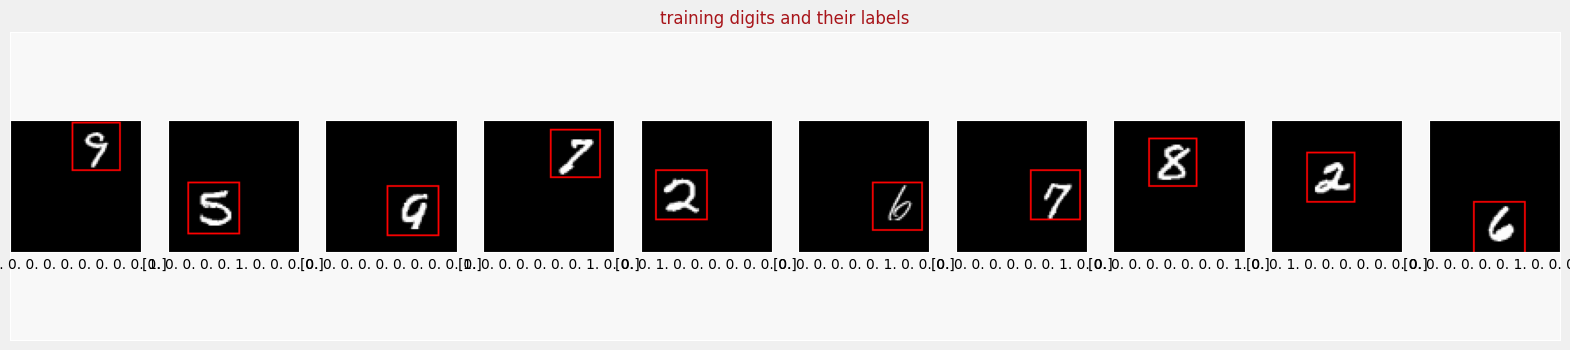

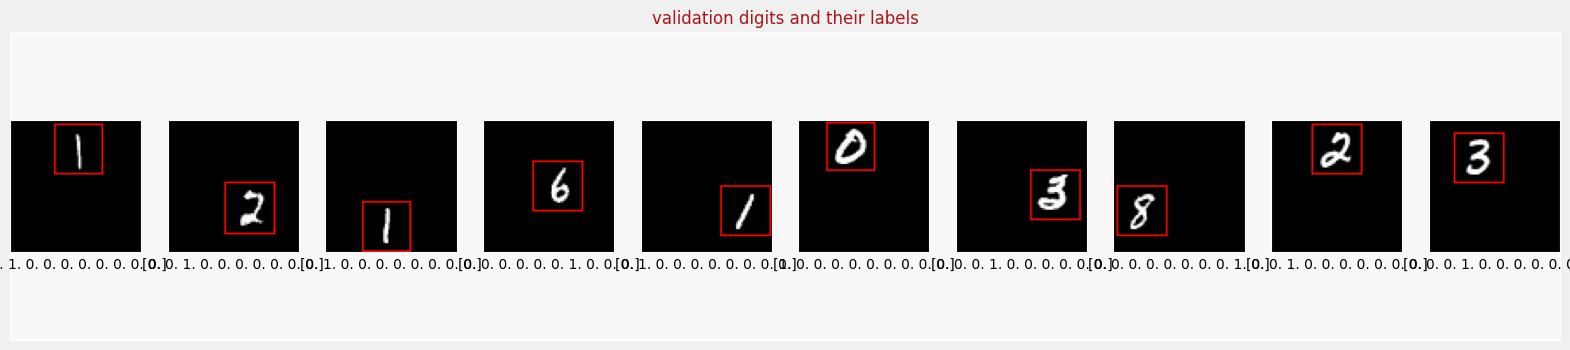

In [ ]:
# (training_digits, training_labels, training_bboxes,
#  validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset,
#                                                                                   validation_dataset,
#                                                                                   10)

display_digits_with_boxes(num_trainImages, num_trainLabels, num_trainLabels,
                          np.array([]), num_trainBboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(num_testImages, num_testLabels, num_testLabels,
                          np.array([]), num_testBboxes, np.array([]), "validation digits and their labels")


#Define the Network#

Images are 75 ⋆ 75 so we can not have so deep networks. and the task of the NN is not that hard it can handle it in some convolutions and fully connected layers. We do not use transfer learning ( pre-trained networks like mobileNet or ResNet ...)

In [ ]:
from tensorflow import keras
from keras import layers
def featEx(input):
  x = layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(75, 75, 1))(input)
  x = layers.AveragePooling2D((2, 2))(x)
  x = layers.Conv2D(32, kernel_size=3, activation='relu' )(x)
  x = layers.AveragePooling2D((2, 2))(x)
  x = layers.Conv2D(64, kernel_size=3, activation='relu' )(x)
  x = layers.AveragePooling2D((2, 2))(x)
  return x

def flattener(input):
  flat = layers.Flatten()(input)
  flat = layers.Dense(128, activation= 'relu')(flat)
  return flat

def classifier(input):
  class_output = layers.Dense(10, activation= 'softmax', name= 'classification_output')(input)
  return class_output
def locator(input):
  loc_output = layers.Dense(4, name = 'localization_output')(input)
  return loc_output

def finalModel(input):
  feat = featEx(input)
  flat = flattener(feat)
  classification = classifier(flat)
  localization = locator(flat)
  model = tf.keras.Model(inputs=input, outputs = [classification, localization] )
  return model

def modelCompile(input):
  model = finalModel(input)
  model.compile(optimizer='adam', loss={'classification_output' : 'categorical_crossentropy',
                                        'localization_output': 'mse'},
                metrics={'classification_output' : 'accuracy',
                         'localization_output'  : 'mse'})
  return model
startingLayer = layers.Input(shape=(75, 75, 1))
model = modelCompile(startingLayer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['average_pooling2d[0][0]'

#Fit the Dataset to the Network

In [ ]:
history = model.fit(num_trainImages, [num_trainLabels, num_trainBboxes],
                    batch_size=32, epochs = 10, validation_data=(num_testImages,
                     [num_testLabels, num_testBboxes]))


# (loss, classification_loss, bounding_box_loss,
#  classification_accuracy, bounding_box_mse) = model.evaluate(num_trainImages,
#                                                              [num_trainLabels, num_trainBboxes],
#                                                              steps=1)
# print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
1875/1875 [==============================] - 30s 7ms/step - loss: 0.7710 - classification_output_loss: 0.7601 - localization_output_loss: 0.0109 - classification_output_accuracy: 0.7382 - localization_output_mse: 0.0109 - val_loss: 0.2687 - val_classification_output_loss: 0.2635 - val_localization_output_loss: 0.0052 - val_classification_output_accuracy: 0.9214 - val_localization_output_mse: 0.0052
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2290 - classification_output_loss: 0.2255 - localization_output_loss: 0.0035 - classification_output_accuracy: 0.9311 - localization_output_mse: 0.0035 - val_loss: 0.1583 - val_classification_output_loss: 0.1557 - val_localization_output_loss: 0.0026 - val_classification_output_accuracy: 0.9495 - val_localization_output_mse: 0.0026
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1565 - classification_output_loss: 0.1542 - localization_output_loss: 0.0023 - classification_o

In [ ]:
(loss, classification_loss, bounding_box_loss,
 classification_accuracy, bounding_box_mse) = model.evaluate(num_trainImages,
                                                             [num_trainLabels, num_trainBboxes])
print("Validation accuracy: ", classification_accuracy)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0458 - classification_output_loss: 0.0441 - localization_output_loss: 0.0017 - classification_output_accuracy: 0.9855 - localization_output_mse: 0.0017
Validation accuracy:  0.985450029373169


#Metrics Evaluation


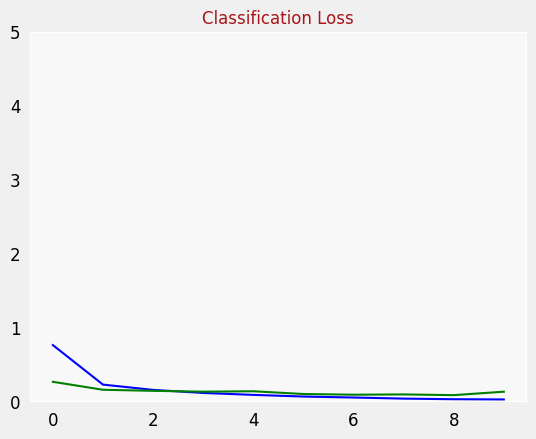

In [ ]:
plot_metrics("classification_output_loss", "Classification Loss")


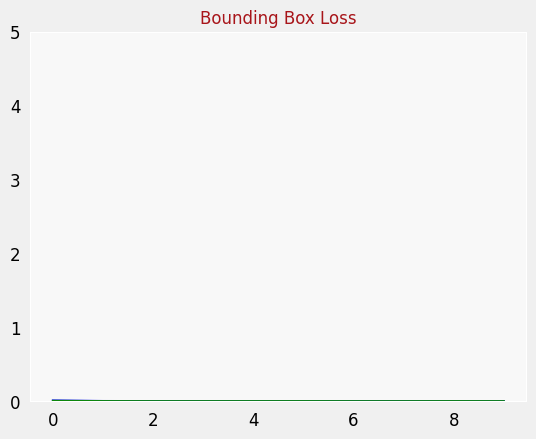

In [ ]:
plot_metrics("localization_output_loss", "Bounding Box Loss")

###intersection over union###

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

157/157 [==============================] - 1s 4ms/step
Number of predictions where iou > threshold(0.6): 8292
Number of predictions where iou < threshold(0.6): 1708


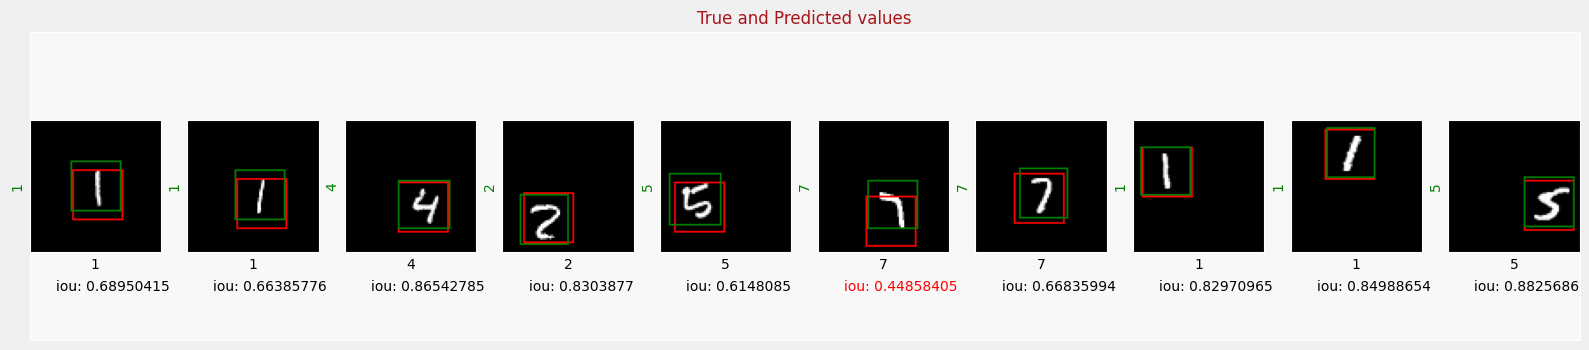

In [ ]:
# recognize validation digits
predictions = model.predict(num_testImages, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, num_testBboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(num_testImages, predicted_labels, num_testLabels, predicted_bboxes, num_testBboxes, iou, "True and Predicted values")